In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.layers import LSTM,Activation,Dense,Dropout,Input,Embedding
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical,pad_sequences
from keras.callbacks import EarlyStopping
%matplotlib inline

Read dataset and do preprocessing

In [7]:
df=pd.read_csv('/content/drive/MyDrive/DataSet/spam.csv',encoding='latin-1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [10]:
df.drop(['Unnamed: 2','Unnamed: 3','Unnamed: 4'],axis=1,inplace=True) 

In [11]:
df.shape

(5572, 2)

Text(0.5, 1.0, 'No.of ham and spam messages')

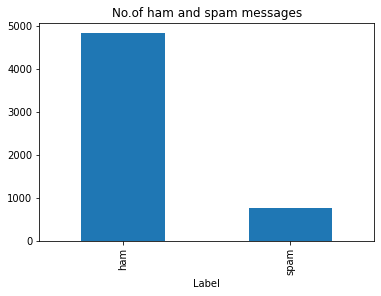

In [12]:
df['v1'].value_counts().plot(kind='bar')
plt.xlabel('Label')
plt.title('No.of ham and spam messages')

In [13]:
X=df.v2
Y=df.v1
le=LabelEncoder()
Y=le.fit_transform(Y)
Y=Y.reshape(-1,1)

In [16]:
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.20)

In [17]:
max_words=1000
max_len=150
tok=Tokenizer(num_words=max_words)
tok.fit_on_texts(X_train)
sequences=tok.texts_to_sequences(X_train)
sequences_matrix=keras.utils.pad_sequences(sequences,maxlen=max_len)

Add Layers(LSTM,Dense-(Hidden Layer),Output)

In [22]:
inputs=Input(name='inputs',shape=[max_len])
layer=Embedding(max_words,50,input_length=max)(inputs)
layer=LSTM(64)(layer)
layer=Dense(256,name='FC1')(layer)
layer=Activation('relu')(layer)
layer=Dropout(0.5)(layer)
layer=Dense(1,name='out_layer')(layer)
layer=Activation('sigmoid')(layer)

Create Model

In [24]:
model=Model(inputs=inputs,outputs=layer)

Compile the Model

In [25]:
model.summary()
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 150)]             0         
                                                                 
 embedding (Embedding)       (None, 150, 50)           50000     
                                                                 
 lstm (LSTM)                 (None, 64)                29440     
                                                                 
 FC1 (Dense)                 (None, 256)               16640     
                                                                 
 activation (Activation)     (None, 256)               0         
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 out_layer (Dense)           (None, 1)                 257   

Fit the Model

In [27]:
model.fit(sequences_matrix,Y_train,batch_size=128,epochs=10,validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)])

Epoch 1/10
28/28 [==============================] - 7s 181ms/step - loss: 0.3450 - accuracy: 0.8729 - val_loss: 0.1919 - val_accuracy: 0.9126
Epoch 2/10
28/28 [==============================] - 5s 164ms/step - loss: 0.1040 - accuracy: 0.9725 - val_loss: 0.0889 - val_accuracy: 0.9776


Save the Model

In [28]:
model.save('spam_lstm_model.h5')

Test the Model

In [34]:
test_sequences=tok.texts_to_sequences(X_test)
test_sequences_matrix=keras.utils.pad_sequences(test_sequences,maxlen=max_len)

In [37]:
accr=model.evaluate(test_sequences_matrix,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

35/35 [==============================] - 0s 14ms/step - loss: 0.0792 - accuracy: 0.9785
Test set
  Loss: 0.079
  Accuracy: 0.978
